In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmasher as cmr
import tensorweave as tw

# Set device
device = "cpu"
dtype = torch.float32

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

In [3]:
# Load the Geyer dataset
import joblib
geyer_dataset = joblib.load("../Datasets/geyer_dataset.pkl")

# Extract the relevant data
xyz = geyer_dataset["xyz"] # Training flight lines
xyz_all = geyer_dataset["xyz_all"] # All flight lines
xyz_test = geyer_dataset["xyz_test"] # Test flight lines
l_id = geyer_dataset["l_id"] # Training line IDs
l_id_all = geyer_dataset["l_id_all"]
l_id_test = geyer_dataset["l_id_test"]
ftg = geyer_dataset["ftg"] # Training FTG
ftg_all = geyer_dataset["ftg_all"]
ftg_test = geyer_dataset["ftg_test"]

In [4]:
# Try importing to run the masking code locally
try :
    import alphashape
    import shapely
    from sklearn.neighbors import KDTree as kdt

    # Create a concave polygon for masking the region of interest
    multipoint = xyz[:, :-1]
    alpha_value = 1.9e-3
    concave_polygon = alphashape.alphashape(multipoint, alpha_value)

    # Create a grid
    inc = 20
    padding = 300
    x_mesh = np.arange(xyz[:, 0].min() - padding, xyz[:, 0].max() + padding, inc)
    y_mesh = np.arange(xyz[:, 1].min() - padding, xyz[:, 1].max() + padding, inc)
    xx, yy = np.meshgrid(x_mesh, y_mesh)
    xvec, yvec = xx.ravel(), yy.ravel()
    zvec = 25 * np.ones_like(xvec)
    grid = np.c_[xvec, yvec, zvec]

    # Create a mask
    # First do a KDTree approach to remove most points
    known_tree = kdt(xyz[:, :-1])
    init_map_distance, _ = known_tree.query(grid[:, :-1], k=1, return_distance=True)
    init_map = (init_map_distance < 40 * inc).ravel()

    # Now only check the points that are within the concave polygon
    close_grid_points = shapely.points(grid[init_map, :-1])
    final_actv = concave_polygon.contains(close_grid_points)

    # The final mask
    actv = np.zeros_like(init_map)
    actv[init_map] = final_actv

except ImportError:
    # Load the precomputed grid
    print("Required packages for masking are not available. Loading precomputed grid instead.")
    geyer_grid = joblib.load("../Datasets/geyer_grid.pkl")

    # Extract the meshgrid from the precomputed grid
    x_mesh = geyer_grid["x_mesh"]
    y_mesh = geyer_grid["y_mesh"]
    xx = geyer_grid["xx"]
    xvec = xx.ravel()
    yy = geyer_grid["yy"]
    yvec = yy.ravel()
    # We assume a constant z value for the grid
    zvec = 25 * np.ones_like(xvec)
    grid = geyer_grid["grid"]
    actv = geyer_grid["actv"]

In [5]:
# Now only check the points that are within the concave polygon for the test lines
test_points = shapely.points(xyz_test[:, :-1])
test_actv = concave_polygon.contains(test_points)
# Final test set
xyz_test = xyz_test[test_actv, :]
ftg_test = ftg_test[test_actv, :]

In [6]:
# Compute the RBF
from scipy.interpolate import RBFInterpolator as RBF

# Initialise the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=250, smoothing=1e2)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_grid[actv] = rbf_func(grid[actv, :-1])

In [7]:
# Also generate an interpolation using all the lines (To use as ground truth)
rbf_all_func = RBF(xyz_all[:, :-1], ftg_all, neighbors=250, smoothing=1e2)
rbf_all_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_all_grid[actv] = rbf_all_func(grid[actv, :-1])

In [8]:
# Load the model ensemble! (And set the device and dtype)
ens = torch.load("../Models/geyer_ensemble.pkl", map_location=device)
for m in ens.members:
    m.to(device, dtype)
    if hasattr(m, "device"):
        m.device = device

In [9]:
# Evaluate the model on the grid
# Initialise
enf_grid = np.full((xvec.shape[0], 6), np.nan)
enf_std = np.full((xvec.shape[0], 6), np.nan)
# Predict!
enf, std, _ = ens.predict(grid[actv], return_std=True, return_quantiles=None, output="hessian", chunk_size=4096)
# Reshape and assign the predictions
enf_grid[actv] = enf.reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]
enf_std[actv] = std.reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]

Evaluating: 100%|██████████| 50/50 [06:20<00:00,  7.60s/it]


In [25]:
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
enf_labels = [r"$H^{\mathrm{ENF}}_{xx}$", r"$H^{\mathrm{ENF}}_{xy}$", r"$H^{\mathrm{ENF}}_{xz}$",
             r"$H^{\mathrm{ENF}}_{yy}$", r"$H^{\mathrm{ENF}}_{yz}$", r"$H^{\mathrm{ENF}}_{zz}$"]
all_labels = [r"$H^{\mathrm{ALL}}_{xx}$", r"$H^{\mathrm{ALL}}_{xy}$", r"$H^{\mathrm{ALL}}_{xz}$",
              r"$H^{\mathrm{ALL}}_{yy}$", r"$H^{\mathrm{ALL}}_{yz}$", r"$H^{\mathrm{ALL}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
to_plot = [rbf_all_grid, rbf_grid, enf_grid]
label_list = [all_labels, rbf_labels, enf_labels]
# Colormap capping
cmax = 1

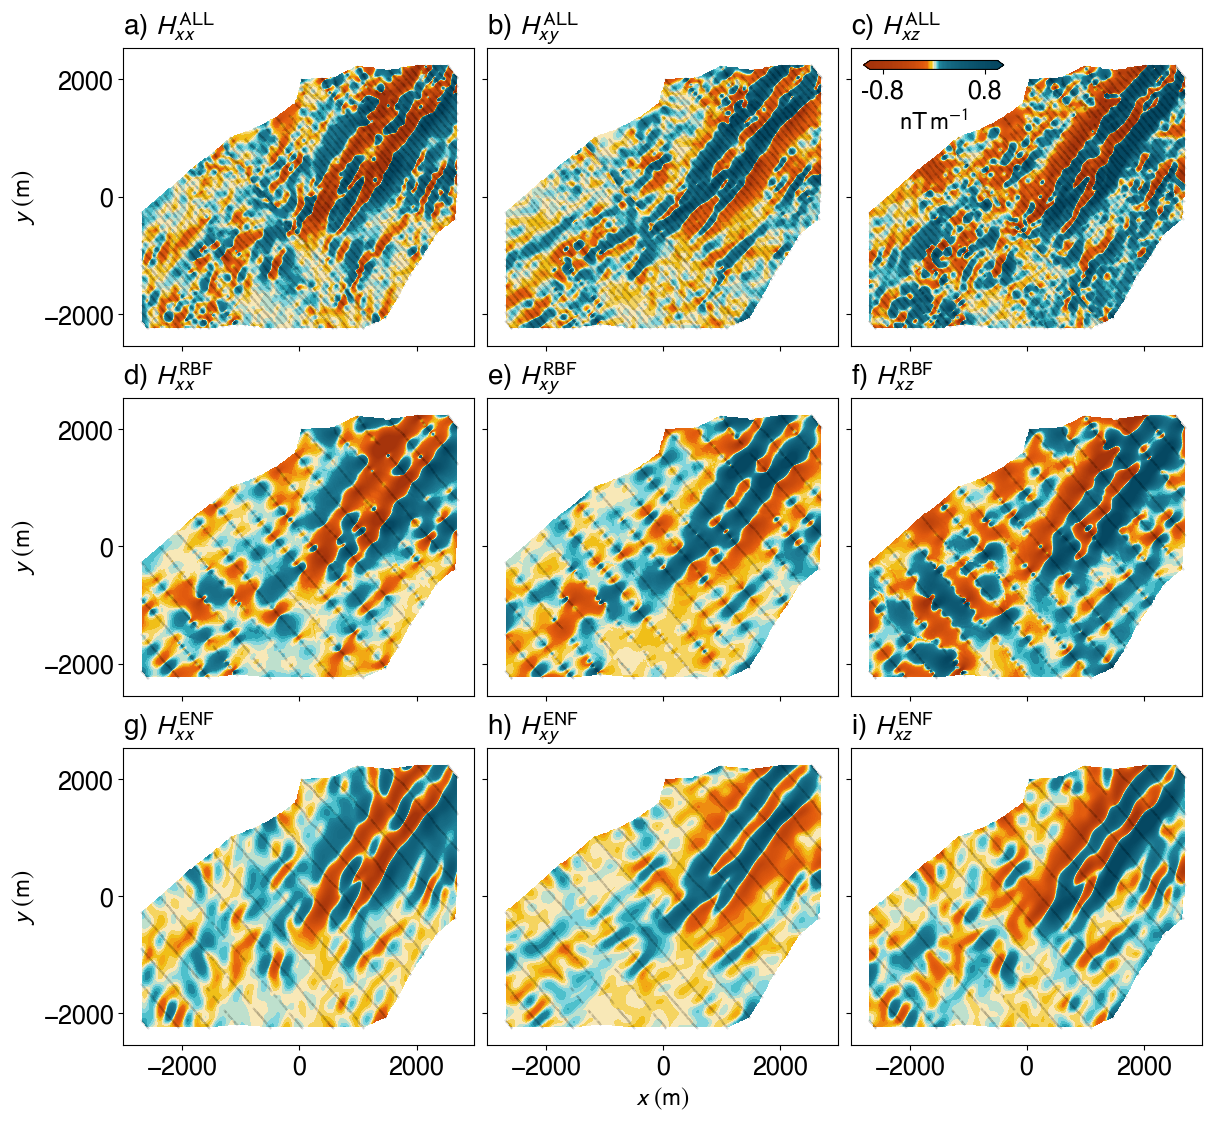

In [55]:
# Plot the NF!
fig, ax = plt.subplots(3, 3, figsize=(12, 12), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) "]

# Contour plots
for i in range(9):
    current_set = to_plot[i // 3]
    m = ax[i].contourf(x_mesh, y_mesh, current_set[:, idx[i % 3]].reshape(xx.shape),
                       levels=np.linspace(-1, 1, 100),
                       extend="both", cmap=curlew_cont,
                       norm=mcolors.SymLogNorm(0.1, 2)
                       )
    ax[i].set_title(plot_labels[i] + label_list[i // 3][idx[i % 3]], loc="left", pad=10)
    if i == 2:
        cbaxes = inset_axes(ax[i], width="40%", height="3%", loc=2)
        plt.colorbar(mappable=m, cax=cbaxes, ticks=[-0.8, 0.8], format="%.1f", orientation="horizontal", label=r"$\mathrm{nT\, m^{-1}}$")

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[6].set_ylabel(r"$y\ (\mathrm{m})$")
ax[7].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz_test[:, 0], xyz_test[:, 1], s=0.1, c='k', alpha=0.2) for a_ in ax[:3]]
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.2) for a_ in ax]

plt.savefig("./Figures/geyer_comparison.png", dpi=350, bbox_inches="tight")
plt.show()

In [12]:
# Integrate the RBF acqquired components
bx_rbf, by_rbf, bz_rbf = tw.spectral_integration(rbf_grid, inc, actv=actv, x_mesh=x_mesh, y_mesh=y_mesh, shape=xx.shape)
b_rbf = np.stack([bx_rbf.ravel(), by_rbf.ravel(), bz_rbf.ravel()], axis=-1)

In [13]:
# Integrate the RBF acqquired components (ALL LINES)
bx_all, by_all, bz_all = tw.spectral_integration(rbf_all_grid, inc, actv=actv, x_mesh=x_mesh, y_mesh=y_mesh, shape=xx.shape)
b_all = np.stack([bx_all.ravel(), by_all.ravel(), bz_all.ravel()], axis=-1)

In [14]:
# Extract the magnetic field values on the grid
mag_field = np.full((xvec.shape[0], 3), np.nan)
mag_std = np.full((xvec.shape[0], 3), np.nan)
mag_field[actv], mag_std[actv], _ = ens.predict(grid[actv], return_std=True, output="gradient", normalize_grad=False)

Evaluating: 100%|██████████| 50/50 [01:40<00:00,  2.00s/it]


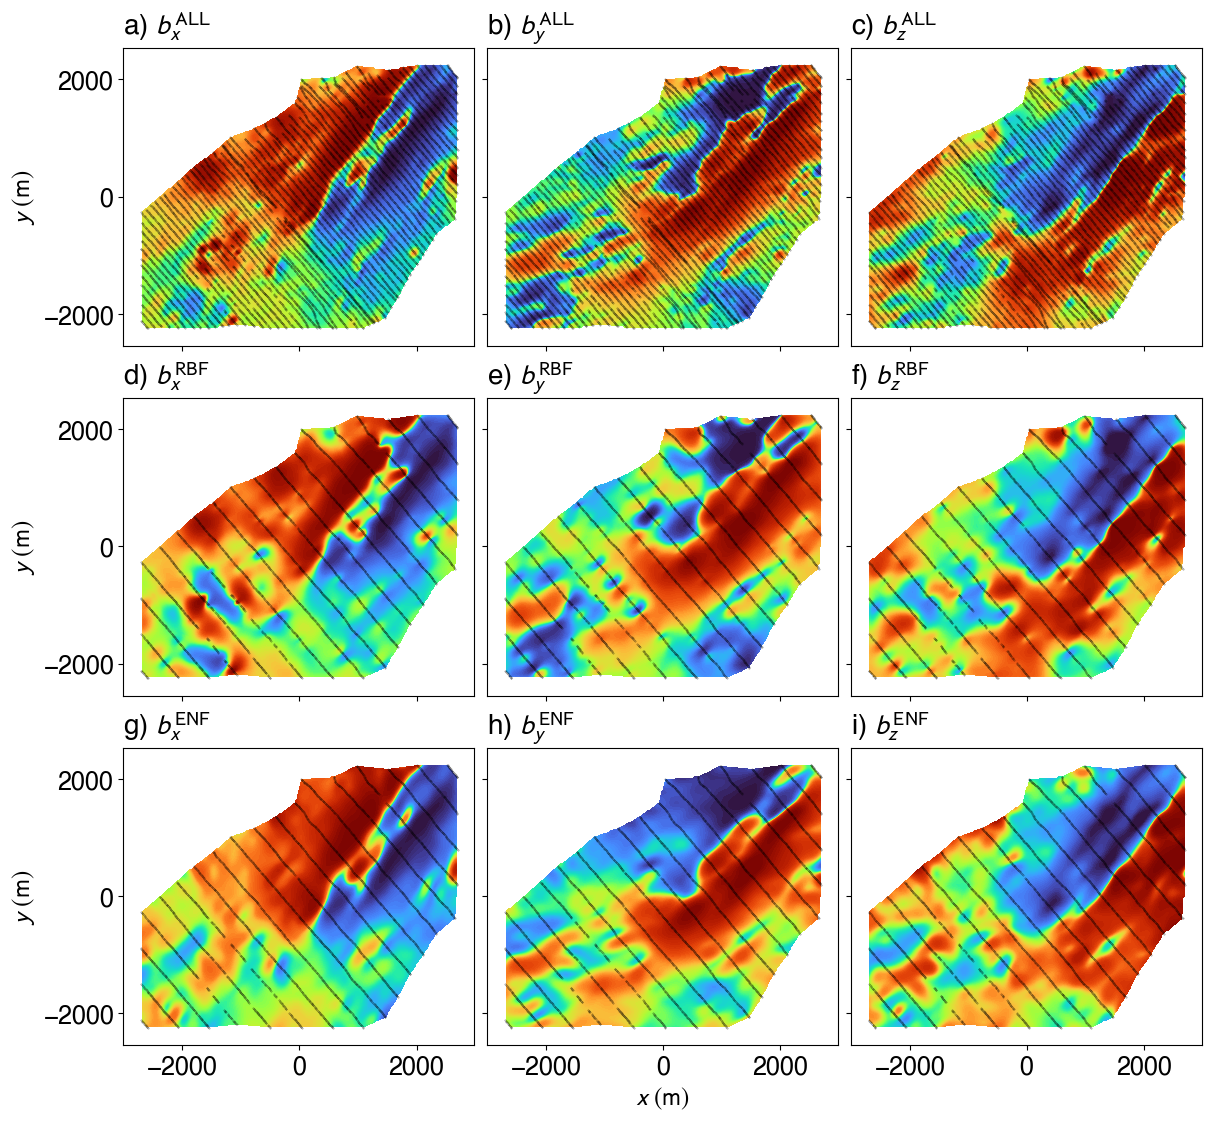

In [15]:
# Plot them together!
b_labels = [r"$b^{\mathrm{ALL}}_{x}$", r"$b^{\mathrm{ALL}}_{y}$", r"$b^{\mathrm{ALL}}_{z}$",
            r"$b^{\mathrm{RBF}}_{x}$", r"$b^{\mathrm{RBF}}_{y}$", r"$b^{\mathrm{RBF}}_{z}$",
            r"$b^{\mathrm{ENF}}_{x}$", r"$b^{\mathrm{ENF}}_{y}$", r"$b^{\mathrm{ENF}}_{z}$"]
to_plot = [b_all, b_rbf, mag_field]

# Plot the magnetic fields!
fig, ax = plt.subplots(3, 3, figsize=(12, 12), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) "]

# Contour plots
for i in range(9):
    current_set = to_plot[i // 3]
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(current_set[:, idx[i % 3]].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap="turbo"
    )
    ax[i].set_title(plot_labels[i] + b_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[6].set_ylabel(r"$y\ (\mathrm{m})$")
ax[7].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz_test[:, 0], xyz_test[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax[:3]]
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.savefig("./Figures/geyer_magnetic_field.png", dpi=350, bbox_inches="tight")
plt.show()

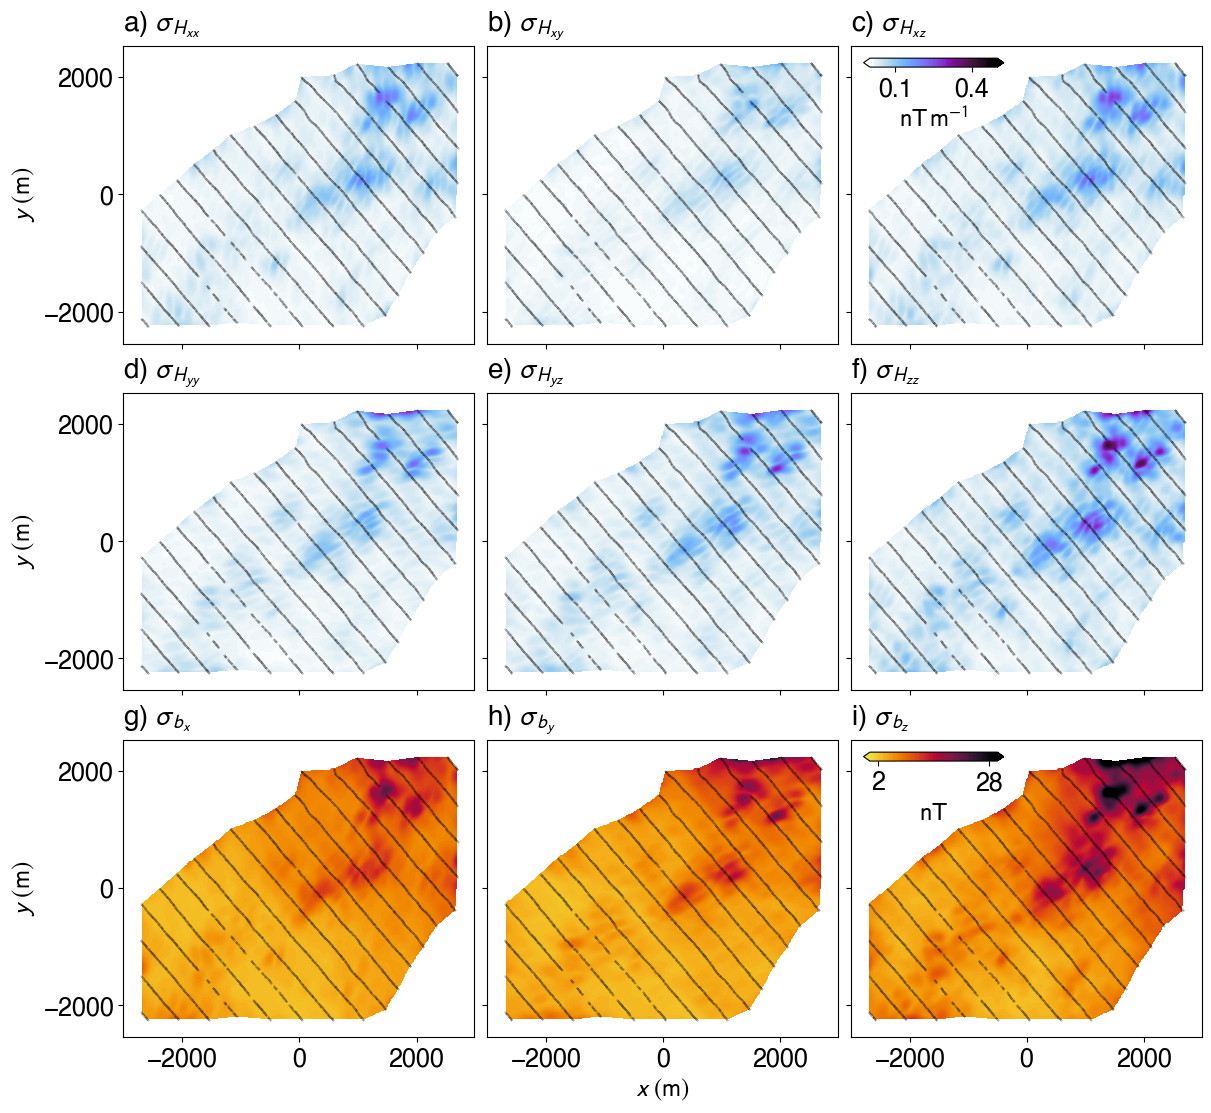

In [57]:
# Plot them together!
b_labels = [r"$\sigma_{H_{xx}}$", r"$\sigma_{H_{xy}}$", r"$\sigma_{H_{xz}}$",
            r"$\sigma_{H_{yy}}$", r"$\sigma_{H_{yz}}$", r"$\sigma_{H_{zz}}$",
            r"$\sigma_{b_{x}}$", r"$\sigma_{b_{y}}$", r"$\sigma_{b_{z}}$"]
to_plot = [enf_std, mag_std]

# Plot the magnetic fields!
fig, ax = plt.subplots(3, 3, figsize=(12, 12), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) "]

# Contour plots
for i in range(9):
    if i < 6:
        m = ax[i].contourf(
            x_mesh, y_mesh, enf_std[:, i].reshape(xx.shape),
            levels=np.linspace(0, 0.5, 100),
            extend="both", cmap=cmr.voltage_r
        )
    else:
        m = ax[i].contourf(
            x_mesh, y_mesh, mag_std[:, i - 6].reshape(xx.shape),
            levels=np.linspace(0, 30, 100),
            extend="both", cmap=cmr.ember_r
        )

    if i == 2:
        cbaxes = inset_axes(ax[i], width="40%", height="3%", loc=2)
        plt.colorbar(mappable=m, cax=cbaxes, ticks=[0.1, 0.4], format="%.1f", orientation="horizontal", label=r"$\mathrm{nT\, m^{-1}}$")
    if i == 8:
        cbaxes = inset_axes(ax[i], width="40%", height="3%", loc=2)
        plt.colorbar(mappable=m, cax=cbaxes, ticks=[2, 28], format="%d", orientation="horizontal", label=r"$\mathrm{nT}$")

    ax[i].set_title(plot_labels[i] + b_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[6].set_ylabel(r"$y\ (\mathrm{m})$")
ax[7].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.savefig("./Figures/geyer_uncertainty.png", dpi=350, bbox_inches="tight")
plt.show()